# PERFORM DIFFERENTIAL ABUNDANCE ANALYSIS ON SCRNA-SEQ DATA FROM NTCU MICE TRACHEA

In [1]:
import warnings

import pandas as pd
# import schist

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import scanpy as sc
import decoupler
import numpy as np
# import tensorflow as tf

# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import seaborn as sns
import altair as alt
import pertpy as pt

Installed version 0.3.0 of pertpy is outdated. Newest version is 0.5.0!

2023-10-31 08:14:03.324585: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# read in epithelial cell data
epithelial_adata = sc.read('/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/NTCU_Trachea_Epithelial_Celltype.h5ad')

In [3]:
# check the object
epithelial_adata

AnnData object with n_obs × n_vars = 45086 × 2264
    obs: 'sample', 'patientID', 'tissue', 'phenotype', 'age', 'scrublet__predicted_multiplet', 'scrublet__multiplet_scores', 'scrublet__multiplet_zscores', 'batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'Montoro_Basal_Score', 'Montoro_Club_Score', 'Montoro_Ciliated_Score', 'Montoro_Tuft_Score', 'Montoro_Neuroendocrine_Score', 'Montoro_Ionocyte_Score', 'Hurskainen_AT2_Score', 'Hurskainen_AT1_Score', 'Hurskainen_Ciliated_Score', 'Hurskainen_Club_Score', 'Chen_AT2_Score', 'Chen_Club_Score', 'Chen_AT1_Score', 'Chen_Basal_Score', 'Chen_Goblet_Score', 'Chen_Krt8_Score', 'Chen_Proliferation_Score', 'Chen_Club_Progenitor_Score', 'Chen_AT1_AT2_Score', 'Chen_Activated_Club_Score', 'Chen_Tumour_Score', 'Chen_DATP_Score', 'Chen_PATS_Score', 'Goldfarbmuren

In [4]:
# initiate scCODA
sccoda_model = pt.tl.Sccoda()

In [5]:
# create MuData object with respective information
sccoda_data = sccoda_model.load(
    epithelial_adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="epithelial_celltypes",
    sample_identifier="patientID",
    covariate_obs=["phenotype", "age", "batch"],
)
sccoda_data

MuData object with n_obs × n_vars = 45100 × 2270
  var:	'n_cells'
  2 modalities
    rna:	45086 x 2264
      obs:	'sample', 'patientID', 'tissue', 'phenotype', 'age', 'scrublet__predicted_multiplet', 'scrublet__multiplet_scores', 'scrublet__multiplet_zscores', 'batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'Montoro_Basal_Score', 'Montoro_Club_Score', 'Montoro_Ciliated_Score', 'Montoro_Tuft_Score', 'Montoro_Neuroendocrine_Score', 'Montoro_Ionocyte_Score', 'Hurskainen_AT2_Score', 'Hurskainen_AT1_Score', 'Hurskainen_Ciliated_Score', 'Hurskainen_Club_Score', 'Chen_AT2_Score', 'Chen_Club_Score', 'Chen_AT1_Score', 'Chen_Basal_Score', 'Chen_Goblet_Score', 'Chen_Krt8_Score', 'Chen_Proliferation_Score', 'Chen_Club_Progenitor_Score', 'Chen_AT1_AT2_Score', 'Chen_Activated_Club_Score', 'Chen_Tumour_Score', 'Chen_DATP_Score', 'Chen_PATS_Score', 'Goldfarbmuren_SMG_Basal_Score', 'Goldfarbmuren_Ciliated_Score', 'Goldfarbmuren_Diff_Basal_Score', 'Goldfarbmuren_Ionocytes_Tuft_Score', 'Goldfarbmuren_Krt8_High_Score', 'Goldfarbmuren_Mucus_Secretory_Score', 'Goldfarbmuren_PNEC_Score', 'Goldfarbmuren_Proliferating_Basal_Score', 'Goldfarbmuren_Proteasomal_Basal_Score', 'Goldfarbmuren_SMG_Secretory_Score', 'Goldfarbmuren_Core_Response_Down_Score', 'Goldfarbmuren_Core_Response_Up_Score', 'epithelial_celltypes', 'scCODA_sample_id'
      var:	'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'ribo', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'age_colors', 'epithelial_celltypes_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'patientID_colors', 'pca', 'phenotype_colors', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    coda:	14 x 6
      obs:	'phenotype', 'age', 'batch', 'patientID'
      var:	'n_cells'

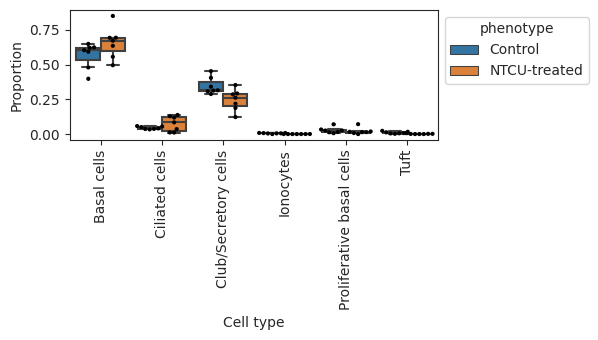

In [13]:
# get an overview of the distrubtion per sample
# the red dots show the actual data points
pt.pl.coda.boxplots(
    sccoda_data,
    modality_key="coda",
    feature_name="phenotype",
    figsize=(6, 3.5),
    add_dots=True,
    args_swarmplot={"palette": ["black"], "size": int(3)},
    cmap=['#2077B5', '#F57E20']
)
plt.savefig("NTCU_Celltype_proportion.pdf")

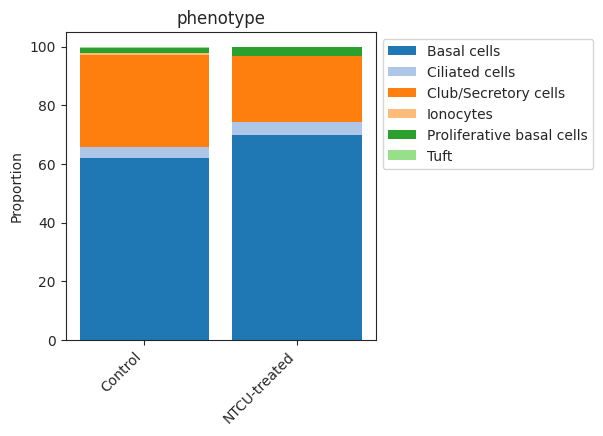

In [7]:
# show this as a stacked barplot
pt.pl.coda.stacked_barplot(
    sccoda_data, 
    modality_key="coda", 
    feature_name="phenotype", 
    figsize=(4, 4)
)
plt.savefig("NTCU_Celltype_proportion_stackedBarplot.pdf")

In [14]:
# run sccoda with automatic reference cell type
# scCODA can either automatically select an appropriate cell type as reference, 
# which is a cell type that has nearly constant relative abundance over all samples
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="phenotype + age + batch",
    reference_cell_type="Ciliated cells"
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda", rng_key=1234)

Zero counts encountered in data! Added a pseudocount of 0.5.

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
sample: 100%|██████████| 11000/11000 [03:27<00:00, 53.07it/s, 511 steps of size 1.19e-02. acc. prob=0.63] 


In [15]:
sccoda_data

MuData object with n_obs × n_vars = 45100 × 2270
  var:	'n_cells'
  2 modalities
    rna:	45086 x 2264
      obs:	'sample', 'patientID', 'tissue', 'phenotype', 'age', 'scrublet__predicted_multiplet', 'scrublet__multiplet_scores', 'scrublet__multiplet_zscores', 'batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'Montoro_Basal_Score', 'Montoro_Club_Score', 'Montoro_Ciliated_Score', 'Montoro_Tuft_Score', 'Montoro_Neuroendocrine_Score', 'Montoro_Ionocyte_Score', 'Hurskainen_AT2_Score', 'Hurskainen_AT1_Score', 'Hurskainen_Ciliated_Score', 'Hurskainen_Club_Score', 'Chen_AT2_Score', 'Chen_Club_Score', 'Chen_AT1_Score', 'Chen_Basal_Score', 'Chen_Goblet_Score', 'Chen_Krt8_Score', 'Chen_Proliferation_Score', 'Chen_Club_Progenitor_Score', 'Chen_AT1_AT2_Score', 'Chen_Activated_Club_Score', 'Chen_Tumour_Score', 'Chen_DATP_Score', 'Chen_PATS_Score', 'Goldfarbmuren_SMG_Basal_Score', 'Goldfarbmuren_Ciliated_Score', 'Goldfarbmuren_Diff_Basal_Score', 'Goldfarbmuren_Ionocytes_Tuft_Score', 'Goldfarbmuren_Krt8_High_Score', 'Goldfarbmuren_Mucus_Secretory_Score', 'Goldfarbmuren_PNEC_Score', 'Goldfarbmuren_Proliferating_Basal_Score', 'Goldfarbmuren_Proteasomal_Basal_Score', 'Goldfarbmuren_SMG_Secretory_Score', 'Goldfarbmuren_Core_Response_Down_Score', 'Goldfarbmuren_Core_Response_Up_Score', 'epithelial_celltypes', 'scCODA_sample_id'
      var:	'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'ribo', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'age_colors', 'epithelial_celltypes_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'patientID_colors', 'pca', 'phenotype_colors', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    coda:	14 x 6
      obs:	'phenotype', 'age', 'batch', 'patientID'
      var:	'n_cells'
      uns:	'scCODA_params'
      obsm:	'covariate_matrix', 'sample_counts'
      varm:	'intercept_df', 'effect_df_phenotype[T.NTCU-treated]', 'effect_df_age[T.30 weeks]', 'effect_df_batch[T.1]', 'effect_df_batch[T.2]', 'effect_df_batch[T.3]', 'effect_df_batch[T.4]', 'effect_df_batch[T.5]', 'effect_df_batch[T.6]', 'effect_df_batch[T.7]', 'effect_df_batch[T.8]', 'effect_df_batch[T.9]', 'effect_df_batch[T.10]', 'effect_df_batch[T.11]', 'effect_df_batch[T.12]', 'effect_df_batch[T.13]'

In [16]:
# check the results
sccoda_data["coda"].varm["effect_df_phenotype[T.NTCU-treated]"]

,Final Parameter,HDI 3%,HDI 97%,SD,Inclusion probability,Expected Sample,log2-fold change
Cell Type,,,,,,,
Basal cells,0.000000,-0.809,0.099,0.254,0.5884,2307.507797,0.222992
Ciliated cells,0.000000,0.000,0.000,0.000,0.0000,150.946179,0.222992
Club/Secretory cells,-0.622294,-1.110,-0.132,0.285,0.9550,623.674759,-0.674789
Ionocytes,0.000000,-2.160,0.051,0.693,0.8432,17.600430,0.222992
Proliferative basal cells,0.000000,-0.399,0.881,0.243,0.4337,100.075344,0.222992
Tuft,0.000000,-1.400,0.183,0.438,0.6094,20.945490,0.222992


In [17]:
# evaluate the results with an FDR < 0.05
sccoda_model.set_fdr(sccoda_data, 0.1)

In [18]:
# investigate which cell types are significantly more or less present 
sccoda_model.credible_effects(sccoda_data, modality_key="coda")["phenotype[T.NTCU-treated]"]

Cell Type
Basal cells                  False
Ciliated cells               False
Club/Secretory cells          True
Ionocytes                     True
Proliferative basal cells    False
Tuft                         False
Name: Final Parameter, dtype: bool

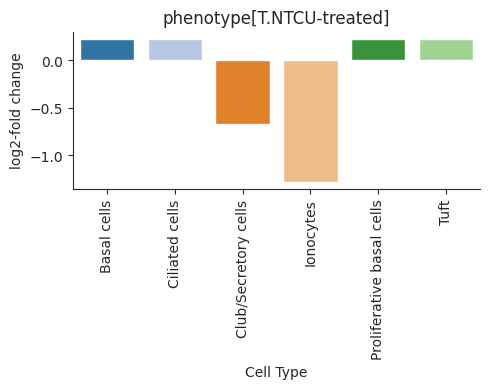

In [24]:
# visualise these changes with barplots
pt.pl.coda.effects_barplot(sccoda_data, "coda", "phenotype", figsize=(2.5, 5))
plt.savefig("scCODA_log2FC_Barplot.pdf")

## PERFORM PSEUDOBULK DIFFERENTIAL GENE EXPRESSION ANALYSIS

In [4]:
# Retrieving via python
msigdb = decoupler.get_resource("MSigDB")

# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
msigdb

# Translate targets
mouse_msigdb = decoupler.translate_net(msigdb, target_organism = 'mouse', unique_by = ('geneset', 'genesymbol'))
mouse_msigdb

,genesymbol,collection,geneset
0,Maff,hallmark,HALLMARK_IL2_STAT5_SIGNALING
1,Maff,hallmark,HALLMARK_COAGULATION
2,Maff,hallmark,HALLMARK_HYPOXIA
3,Maff,hallmark,HALLMARK_TNFA_SIGNALING_VIA_NFKB
4,Maff,hallmark,HALLMARK_COMPLEMENT
...,...,...,...
7507,Stxbp1,hallmark,HALLMARK_PANCREAS_BETA_CELLS
7508,Elp4,hallmark,HALLMARK_PANCREAS_BETA_CELLS
7509,Gcg,hallmark,HALLMARK_PANCREAS_BETA_CELLS
7510,Pcsk2,hallmark,HALLMARK_PANCREAS_BETA_CELLS


In [5]:
# Filtering genesets to match behaviour of fgsea
geneset_size = mouse_msigdb.groupby("geneset").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

In [6]:
# subset whole dataset to the individual clusters present in the epithelial cell compartment
epithelial_cells = epithelial_adata.obs_names
epithelial_cells

adata = sc.read('/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/NTCU_GEX_Trachea_raw.h5ad')
adata = adata[epithelial_cells,]

In [7]:
adata.obs = epithelial_adata.obs

In [8]:
# Get pseudo-bulk profile
pdata = decoupler.get_pseudobulk(adata,
                          sample_col='phenotype',
                          groups_col='epithelial_celltypes',
                          mode='sum',
                          min_cells=0,
                          min_counts=0
                         )
pdata

AnnData object with n_obs × n_vars = 12 × 24900
    obs: 'tissue', 'phenotype', 'scrublet__predicted_multiplet', 'epithelial_celltypes', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'ribo'
    layers: 'psbulk_props'

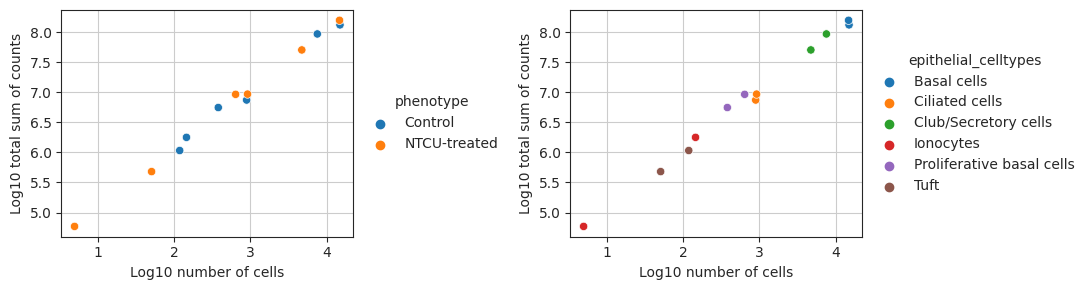

In [9]:
decoupler.plot_psbulk_samples(pdata, groupby=['phenotype', 'epithelial_celltypes'], figsize=(11, 3))

In [10]:
# Get pseudo-bulk profile
pdata = decoupler.get_pseudobulk(adata,
                          sample_col='patientID',
                          groups_col='epithelial_celltypes',
                          mode='sum',
                          min_cells=100,
                          min_counts=5000
                         )
pdata

AnnData object with n_obs × n_vars = 27 × 24833
    obs: 'sample', 'patientID', 'tissue', 'phenotype', 'age', 'scrublet__predicted_multiplet', 'batch', 'epithelial_celltypes', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'ribo'
    layers: 'psbulk_props'

### ANALYSE CILIATED CELLS

In [11]:
# Select squamous suprabasal cell profiles
ciliated_cells = pdata[pdata.obs['epithelial_celltypes'] == 'Ciliated cells'].copy()

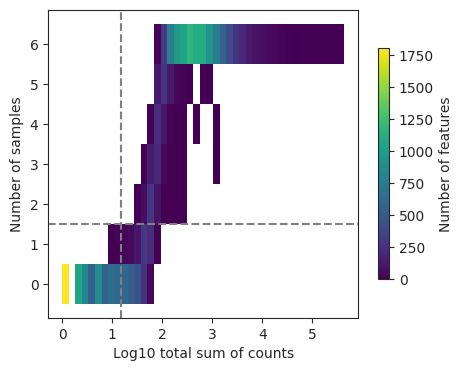

In [12]:
decoupler.plot_filter_by_expr(ciliated_cells, group='phenotype', min_count=10, min_total_count=15)

In [13]:
# Obtain genes that pass the thresholds
genes = decoupler.filter_by_expr(ciliated_cells, group='phenotype', min_count=10, min_total_count=15)

# Filter by these genes
ciliated_cells = ciliated_cells[:, genes].copy()

# Build DESeq2 object
dds = DeseqDataSet(
    adata=ciliated_cells,
    design_factors=['phenotype', 'age'],
    refit_cooks=True,
    n_cpus=8,
)

# Compute LFCs
dds.deseq2()

# Extract contrast between NTCU-treated vs control
stat_res = DeseqStats(dds, contrast=["phenotype", 'NTCU-treated', 'Control'], n_cpus=8)

# Compute Wald test
stat_res.summary()

# Shrink LFCs
# stat_res.lfc_shrink()
stat_res.lfc_shrink(coeff='phenotype_NTCU-treated_vs_Control')

# Extract results
results_df = stat_res.results_df
results_df.to_csv("/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/NTCU_DESeq2_Ciliated_cells_NTCU_vs_control.csv")

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 111.64 seconds.

Fitting dispersion trend curve...
... done in 4.77 seconds.

Fitting MAP dispersions...
... done in 90.20 seconds.

Fitting LFCs...
... done in 9.39 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 2.90 seconds.

Log2 fold change & Wald test p-value: phenotype NTCU-treated vs Control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0610009B22Rik,61.142651,0.161696,0.584832,0.276484,0.782177,0.997244
0610009E02Rik,43.536060,-0.289189,0.177334,-1.630764,0.102940,0.654019
0610009L18Rik,31.572853,0.289562,0.198436,1.459226,0.144503,0.744468
0610010F05Rik,123.611488,0.083743,0.141012,0.593871,0.552598,0.997244
0610010K14Rik,112.544975,-0.265599,0.234657,-1.131860,0.257693,0.889502
...,...,...,...,...,...,...
mt-Nd3,53.924816,-0.178102,0.151572,-1.175032,0.239982,0.875427
mt-Nd4,4319.637207,-0.333599,0.217290,-1.535271,0.124717,0.705023
mt-Nd4l,10099.916992,-0.561187,0.274337,-2.045614,0.040794,0.426791
mt-Nd5,3237.823975,-0.518129,0.235216,-2.202780,0.027610,0.345260


Fitting MAP LFCs...
... done in 21.15 seconds.

Shrunk Log2 fold change & Wald test p-value: phenotype NTCU-treated vs Control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0610009B22Rik,61.142651,0.006044,0.132194,0.276484,0.782177,0.997244
0610009E02Rik,43.536060,-0.144270,0.524362,-1.630764,0.102940,0.654019
0610009L18Rik,31.572853,-0.144270,0.524362,1.459226,0.144503,0.744468
0610010F05Rik,123.611488,0.035491,0.108701,0.593871,0.552598,0.997244
0610010K14Rik,112.544975,-0.057846,0.139348,-1.131860,0.257693,0.889502
...,...,...,...,...,...,...
mt-Nd3,53.924816,-0.144270,0.524362,-1.175032,0.239982,0.875427
mt-Nd4,4319.637207,-0.087207,0.156927,-1.535271,0.124717,0.705023
mt-Nd4l,10099.916992,-0.092788,0.180234,-2.045614,0.040794,0.426791
mt-Nd5,3237.823975,-0.141038,0.219516,-2.202780,0.027610,0.345260


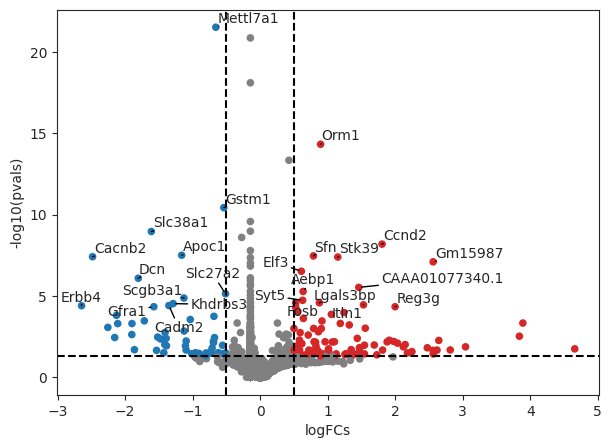

In [14]:
decoupler.plot_volcano_df(results_df, x='log2FoldChange', y='padj', top=25, save = 'ciliated_cell_volcano.pdf')

In [15]:
# create matrix format for input to downstream analysis
mat = results_df[['stat']].T.rename(index={'stat': 'Ciliated cells'})

# Retrieve CollecTRI gene regulatory network (replaces dorothea)
collectri = decoupler.get_collectri(organism='Mus musculus', split_complexes=False)

# Infer pathway activities with univariate linear model (ulm)
# For each sample in our dataset (mat) and each TF in our network (net), it fits a linear model
# that predicts the observed gene expression based solely on the TF’s TF-Gene interaction weights. 
# Once fitted, the obtained t-value of the slope is the score. 
# If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive.
tf_acts, tf_pvals = decoupler.run_ulm(mat=mat, net=collectri)

# create a dictionary
data = {"activities": tf_acts,
        "pvals": tf_pvals}

df = pd.concat(data,
               axis = 0)
df.to_csv('/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/Ciliated_cells_NTCU_vs_Control_collectTRI_results.csv')

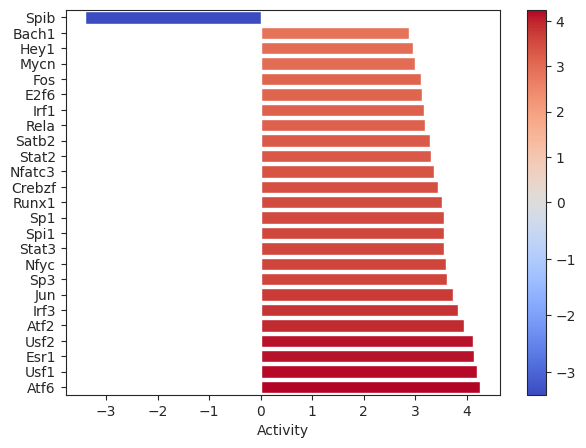

In [16]:
# top 25 according to significance and score
decoupler.plot_barplot(tf_acts, 'Ciliated cells', top=25, vertical=True, save = 'ciliated_cell_dorothea.pdf')

In [17]:
# Retrieve PROGENy model weights
# this takes into account the top 100 DEGs ranked by p-value
progeny = decoupler.get_progeny(organism='Mus musculus', top=100)

# Infer pathway activities with multivariate linear model (mlm)
# It fits a linear model that predicts the observed gene expression based on all pathways’ Pathway-Gene interactions weights. 
# Once fitted, the obtained t-values of the slopes are the scores. 
# If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.
pathway_acts, pathway_pvals = decoupler.run_mlm(mat=mat, net=progeny)

# create a dictionary
data = {"activities": pathway_acts,
        "pvals": pathway_pvals}
df = pd.concat(data, axis = 0)
df.to_csv('/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/Ciliated_cells_NTCU_vs_Control_progeny_results.csv')

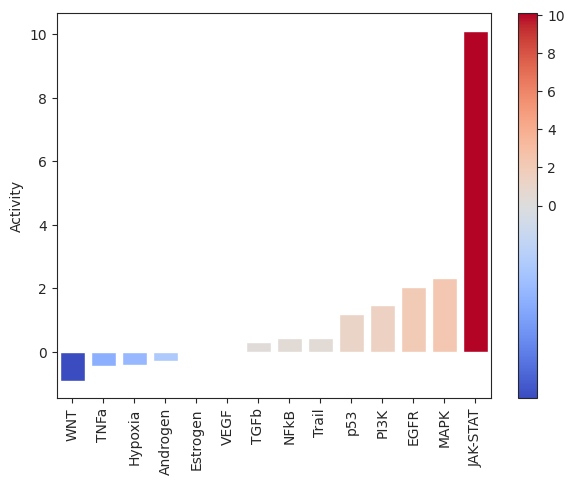

In [19]:
decoupler.plot_barplot(pathway_acts, 'Ciliated cells', top=25, vertical=False, save = 'ciliated_cell_progeny.pdf')

In [ ]:
decoupler.plot_targets(results_df, stat='stat', source_name='JAK-STAT', net=progeny, top=15, save = 'ciliated_cell_progeny_JAK.pdf')

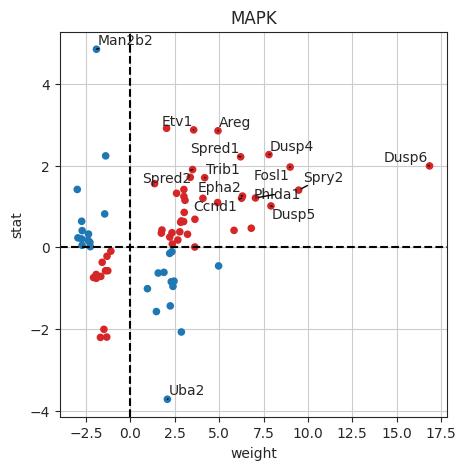

In [21]:
decoupler.plot_targets(results_df, stat='stat', source_name='MAPK', net=progeny, top=15, save = 'ciliated_cell_progeny_MAPK.pdf')

In [22]:
# Infer enrichment with over representation analysis (ora) using significant deg
# As input data it accepts the results of differential expression analysis (decoupler.run_ora_df).
# For this a user-defined significance filtering can be used. 
# Once we have S*, it builds a contingency table using set operations for each set stored in the gene set resource being used (net).
# Using the contingency table, ora performs a one-sided Fisher exact test to test for significance of overlap between sets. 
# The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.
top_genes = results_df[results_df['padj'] < 0.05].reset_index()
top_genes['group'] = 'Ciliated cells'
enr_pvals = decoupler.get_ora_df(top_genes, mouse_msigdb, groupby='group', features='index', source='geneset', target='genesymbol')

# create a dictionary
data = {"pvals": enr_pvals}
df = pd.concat(data, axis = 0)
df.to_csv('/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/Ciliated_cells_NTCU_vs_Control_GSEA_results.csv')

# Set 0s to min p-value
enr_pvals.values[enr_pvals.values == 0] = np.min(enr_pvals.values[enr_pvals.values != 0])

# Log-transform
enr_pvals = -np.log10(enr_pvals)

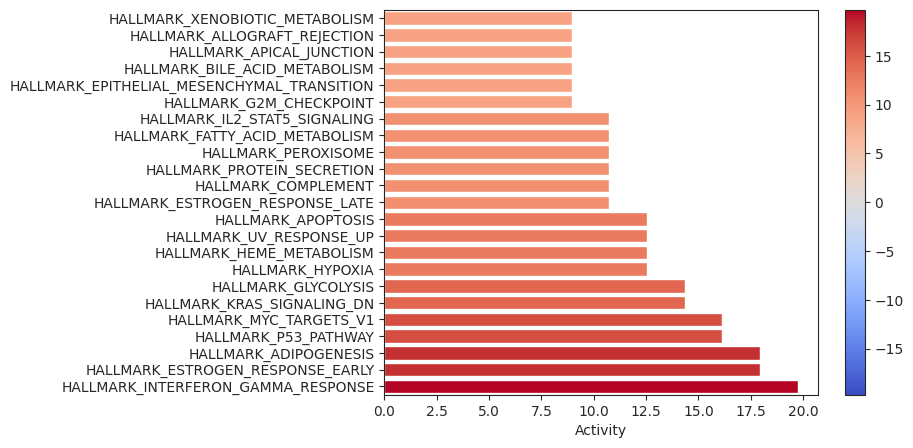

In [23]:
# log transformed p-values
decoupler.plot_barplot(enr_pvals, 'Ciliated cells', top=25, vertical=True)

### ANALYSE BASAL CELLS

In [24]:
# Select basal cell profiles
basal_cells = pdata[pdata.obs['epithelial_celltypes'] == 'Basal cells'].copy()

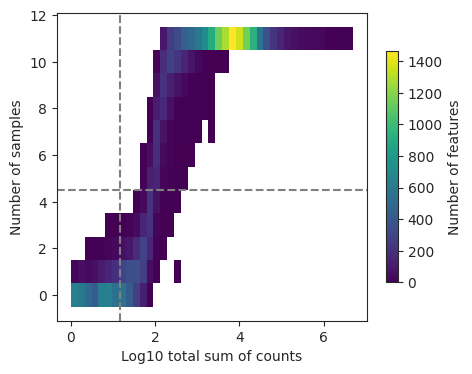

In [25]:
decoupler.plot_filter_by_expr(basal_cells, group='phenotype', min_count=10, min_total_count=15)

In [26]:
# Obtain genes that pass the thresholds
genes = decoupler.filter_by_expr(basal_cells, group='phenotype', min_count=10, min_total_count=15)

# Filter by these genes
basal_cells = basal_cells[:, genes].copy()

# Build DESeq2 object
dds = DeseqDataSet(
    adata=basal_cells,
    design_factors=['phenotype', 'age'],
    refit_cooks=True,
    n_cpus=8,
)

# Compute LFCs
dds.deseq2()

# Extract contrast between NTCU-treated vs control
stat_res = DeseqStats(dds, contrast=["phenotype", 'NTCU-treated', 'Control'], n_cpus=8)

# Compute Wald test
stat_res.summary()

# Shrink LFCs
stat_res.lfc_shrink(coeff='phenotype_NTCU-treated_vs_Control')

# Extract results
results_df = stat_res.results_df
results_df.to_csv("/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/NTCU_DESeq2_Basal_cells_NTCU_vs_Control.csv")

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 162.55 seconds.

Fitting dispersion trend curve...
... done in 6.28 seconds.

Fitting MAP dispersions...
... done in 148.16 seconds.

Fitting LFCs...
... done in 14.12 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 3.75 seconds.

Log2 fold change & Wald test p-value: phenotype NTCU-treated vs Control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0610009B22Rik,498.691589,0.118927,0.104261,1.140666,0.254009,0.440321
0610009E02Rik,39.085155,-0.206438,0.137386,-1.502616,0.132938,0.284392
0610009L18Rik,155.886978,-0.454937,0.167770,-2.711670,0.006695,0.031603
0610010F05Rik,172.663956,-0.066230,0.113117,-0.585496,0.558215,0.727929
0610010K14Rik,884.324036,-0.055447,0.077645,-0.714110,0.475159,0.659352
...,...,...,...,...,...,...
mt-Nd3,493.496674,-0.256220,0.675180,-0.379484,0.704328,0.832300
mt-Nd4,15356.202148,-0.376003,0.199813,-1.881775,0.059867,0.162125
mt-Nd4l,32657.451172,-0.311115,0.177686,-1.750922,0.079959,0.199558
mt-Nd5,12399.975586,-0.598145,0.271774,-2.200895,0.027743,0.092089


Fitting MAP LFCs...
... done in 25.52 seconds.

Shrunk Log2 fold change & Wald test p-value: phenotype NTCU-treated vs Control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0610009B22Rik,498.691589,0.105005,0.101022,1.140666,0.254009,0.440321
0610009E02Rik,39.085155,-0.171367,0.130243,-1.502616,0.132938,0.284392
0610009L18Rik,155.886978,-0.384499,0.165230,-2.711670,0.006695,0.031603
0610010F05Rik,172.663956,-0.056851,0.107895,-0.585496,0.558215,0.727929
0610010K14Rik,884.324036,-0.050901,0.076407,-0.714110,0.475159,0.659352
...,...,...,...,...,...,...
mt-Nd3,493.496674,-0.026418,0.503517,-0.379484,0.704328,0.832300
mt-Nd4,15356.202148,-0.353048,0.202908,-1.881775,0.059867,0.162125
mt-Nd4l,32657.451172,-0.226181,0.176608,-1.750922,0.079959,0.199558
mt-Nd5,12399.975586,-0.439963,0.285193,-2.200895,0.027743,0.092089


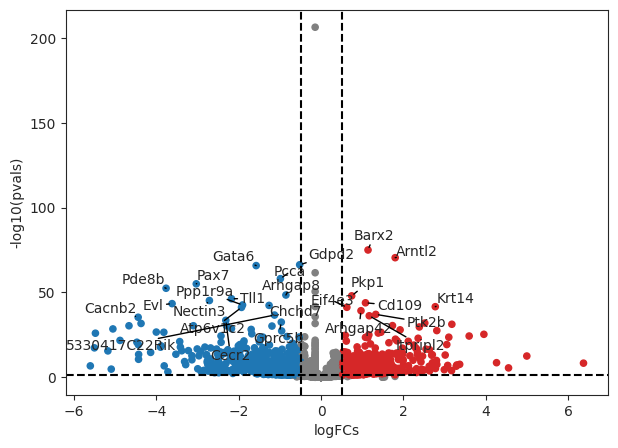

In [27]:
decoupler.plot_volcano_df(results_df, x='log2FoldChange', y='padj', top=25, save= 'basal_cell_volcano.pdf')

In [28]:
# create matrix format for input to downstream analysis
mat = results_df[['stat']].T.rename(index={'stat': 'Basal cells'})

# Infer pathway activities with univariate linear model (ulm)
# For each sample in our dataset (mat) and each TF in our network (net), it fits a linear model
# that predicts the observed gene expression based solely on the TF’s TF-Gene interaction weights. 
# Once fitted, the obtained t-value of the slope is the score. 
# If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive.
tf_acts, tf_pvals = decoupler.run_ulm(mat=mat, net=collectri)

# create a dictionary
data = {"activities": tf_acts,
        "pvals": tf_pvals}

df = pd.concat(data,
               axis = 0)
df.to_csv('/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/Basal_cells_NTCU_vs_Control_collectTRI_results.csv')

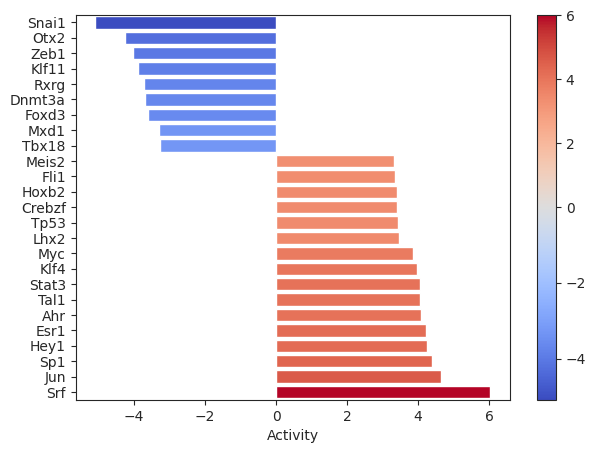

In [29]:
decoupler.plot_barplot(tf_acts, 'Basal cells', top=25, vertical=True, save= 'basal_cell_collectTRI.pdf')

In [30]:
# Infer pathway activities with multivariate linear model (mlm)
# It fits a linear model that predicts the observed gene expression based on all pathways’ Pathway-Gene interactions weights. 
# Once fitted, the obtained t-values of the slopes are the scores. 
# If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.
pathway_acts, pathway_pvals = decoupler.run_mlm(mat=mat, net=progeny)

# create a dictionary
data = {"activities": pathway_acts,
        "pvals": pathway_pvals}
df = pd.concat(data, axis = 0)
df.to_csv('/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/Basal_cells_NTCU_vs_Control_progeny_results.csv')

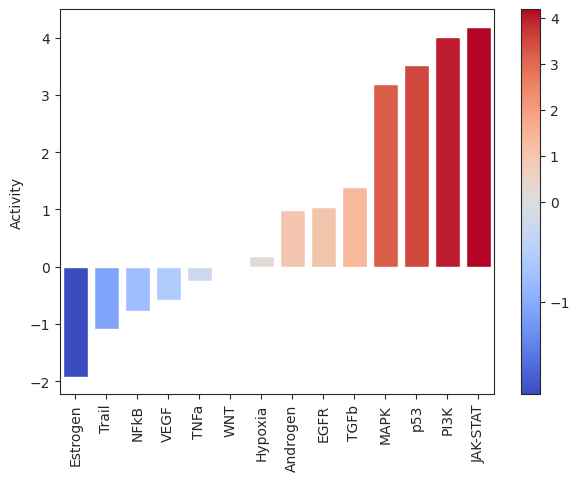

In [31]:
decoupler.plot_barplot(pathway_acts, 'Basal cells', top=25, vertical=False, save= 'basal_cell_progeny.pdf')

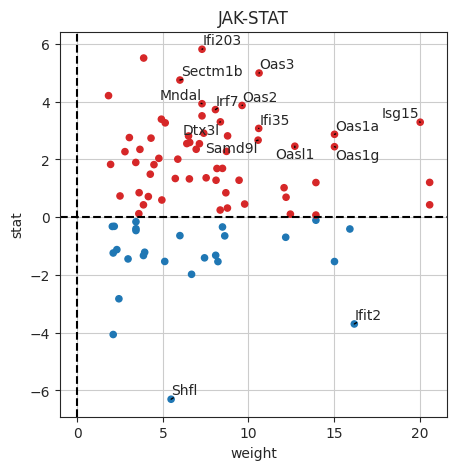

In [32]:
decoupler.plot_targets(results_df, stat='stat', source_name='JAK-STAT', net=progeny, top=15, save = 'basal_cell_progeny_JAK.pdf')

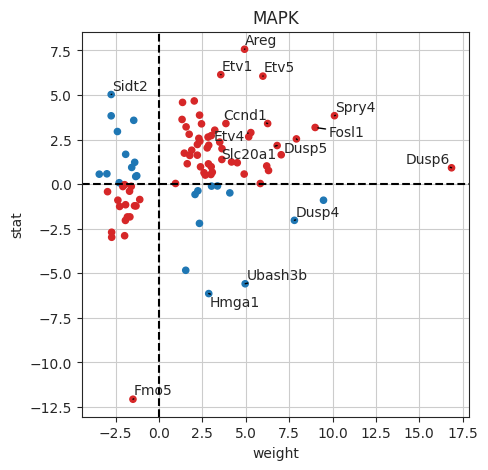

In [33]:
decoupler.plot_targets(results_df, stat='stat', source_name='MAPK', net=progeny, top=15, save = 'basal_cell_progeny_MAPK.pdf')

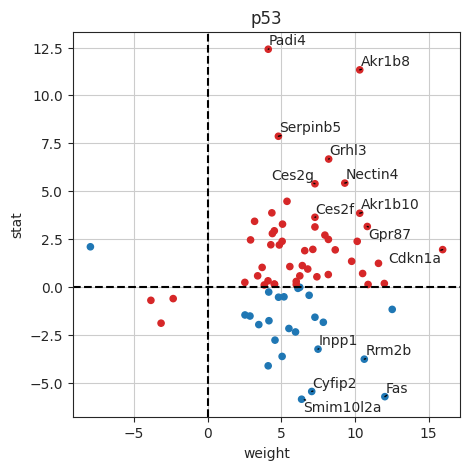

In [34]:
decoupler.plot_targets(results_df, stat='stat', source_name='p53', net=progeny, top=15, save = 'basal_cell_progeny_p53.pdf')

In [56]:
# Infer enrichment with over representation analysis (ora) using significant deg
# As input data it accepts the results of differential expression analysis (decoupler.run_ora_df).
# For this a user-defined significance filtering can be used. 
# Once we have S*, it builds a contingency table using set operations for each set stored in the gene set resource being used (net).
# Using the contingency table, ora performs a one-sided Fisher exact test to test for significance of overlap between sets. 
# The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.
top_genes = results_df[results_df['padj'] < 0.05].reset_index()
top_genes['group'] = 'Basal cells'
top_genes = top_genes.sort_values('log2FoldChange', key = np.abs, ascending = False)
enr_pvals = decoupler.get_ora_df(top_genes, mouse_msigdb, groupby='group', features='index', source='geneset', target='genesymbol')

# create a dictionary
data = {"pvals": enr_pvals}
df = pd.concat(data, axis = 0)
df.to_csv('/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/Basal_cells_NTCU_vs_Control_GSEA_results.csv')

# Set 0s to min p-value
enr_pvals.values[enr_pvals.values == 0] = np.min(enr_pvals.values[enr_pvals.values != 0])

# Log-transform
enr_pvals = -np.log10(enr_pvals)

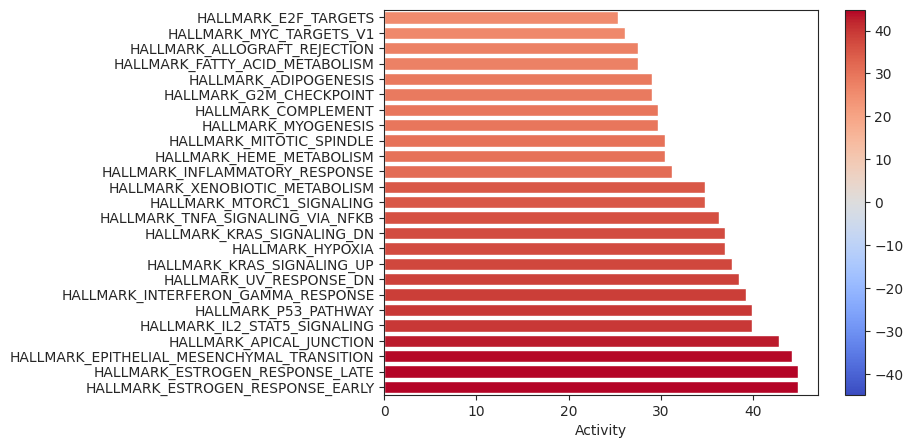

In [57]:
decoupler.plot_barplot(enr_pvals, 'Basal cells', top=25, vertical=True)

### ANALYSE SECRETORY CELLS

In [35]:
# Select basal cell profiles
secretory_cells = pdata[pdata.obs['epithelial_celltypes'] == 'Club/Secretory cells'].copy()

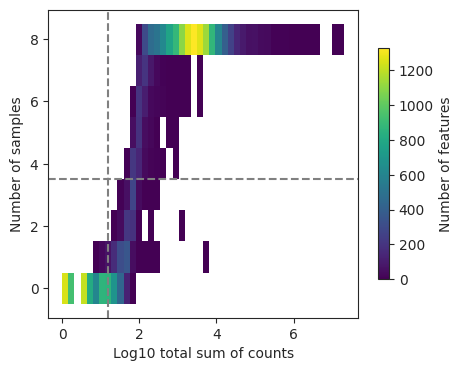

In [36]:
decoupler.plot_filter_by_expr(secretory_cells, group='phenotype', min_count=10, min_total_count=15)

In [37]:
# Obtain genes that pass the thresholds
genes = decoupler.filter_by_expr(secretory_cells, group='phenotype', min_count=10, min_total_count=15)

# Filter by these genes
secretory_cells = secretory_cells[:, genes].copy()

# Build DESeq2 object
dds = DeseqDataSet(
    adata=secretory_cells,
    design_factors=['phenotype', 'age'],
    refit_cooks=True,
    n_cpus=8,
)

# Compute LFCs
dds.deseq2()

# Extract contrast between NTCU-treated vs control
stat_res = DeseqStats(dds, contrast=["phenotype", 'NTCU-treated', 'Control'], n_cpus=8)

# Compute Wald test
stat_res.summary()

# Shrink LFCs
stat_res.lfc_shrink(coeff='phenotype_NTCU-treated_vs_Control')

# Extract results
results_df = stat_res.results_df
results_df.to_csv("/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/NTCU_DESeq2_Secretory_cells_NTCU_vs_Control.csv")

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 127.74 seconds.

Fitting dispersion trend curve...
... done in 5.44 seconds.

Fitting MAP dispersions...
... done in 123.00 seconds.

Fitting LFCs...
... done in 11.34 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 3.33 seconds.

Log2 fold change & Wald test p-value: phenotype NTCU-treated vs Control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0610009B22Rik,426.337891,-0.359611,0.307486,-1.169519,2.421945e-01,3.671689e-01
0610009E02Rik,43.348442,-0.553537,0.269503,-2.053919,3.998356e-02,9.422497e-02
0610009L18Rik,106.529572,-0.861080,0.231157,-3.725087,1.952481e-04,1.277915e-03
0610010F05Rik,187.880524,0.215351,0.153718,1.400944,1.612307e-01,2.709927e-01
0610010K14Rik,672.524658,-0.368898,0.209662,-1.759493,7.849386e-02,1.566238e-01
...,...,...,...,...,...,...
mt-Nd3,616.939514,-0.535291,0.092281,-5.800679,6.604698e-09,1.491904e-07
mt-Nd4,30419.507812,-0.784921,0.157109,-4.996038,5.852014e-07,8.357442e-06
mt-Nd4l,52205.496094,-0.682601,0.151990,-4.491089,7.085980e-06,7.430573e-05
mt-Nd5,23240.312500,-0.964058,0.195729,-4.925474,8.415601e-07,1.154966e-05


Fitting MAP LFCs...
... done in 22.71 seconds.

Shrunk Log2 fold change & Wald test p-value: phenotype NTCU-treated vs Control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0610009B22Rik,426.337891,-0.226706,0.289940,-1.169519,2.421945e-01,3.671689e-01
0610009E02Rik,43.348442,-0.435437,0.260318,-2.053919,3.998356e-02,9.422497e-02
0610009L18Rik,106.529572,-0.765839,0.242409,-3.725087,1.952481e-04,1.277915e-03
0610010F05Rik,187.880524,0.191285,0.147059,1.400944,1.612307e-01,2.709927e-01
0610010K14Rik,672.524658,-0.301041,0.209405,-1.759493,7.849386e-02,1.566238e-01
...,...,...,...,...,...,...
mt-Nd3,616.939514,-0.520767,0.091986,-5.800679,6.604698e-09,1.491904e-07
mt-Nd4,30419.507812,-0.838733,0.156025,-4.996038,5.852014e-07,8.357442e-06
mt-Nd4l,52205.496094,-0.653723,0.147534,-4.491089,7.085980e-06,7.430573e-05
mt-Nd5,23240.312500,-0.926262,0.193317,-4.925474,8.415601e-07,1.154966e-05


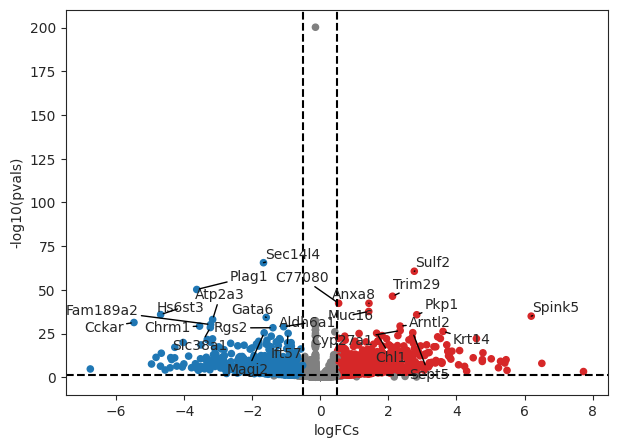

In [38]:
decoupler.plot_volcano_df(results_df, x='log2FoldChange', y='padj', top=25, save = "secretory_cell_volcano.pdf")

In [39]:
# create matrix format for input to downstream analysis
mat = results_df[['stat']].T.rename(index={'stat': 'Secretory cells'})

# Infer pathway activities with univariate linear model (ulm)
# For each sample in our dataset (mat) and each TF in our network (net), it fits a linear model
# that predicts the observed gene expression based solely on the TF’s TF-Gene interaction weights. 
# Once fitted, the obtained t-value of the slope is the score. 
# If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive.
tf_acts, tf_pvals = decoupler.run_ulm(mat=mat, net=collectri)

# create a dictionary
data = {"activities": tf_acts,
        "pvals": tf_pvals}

df = pd.concat(data,
               axis = 0)
df.to_csv('/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/Secretory_cells_NTCU_vs_Control_collectTRI_results.csv')

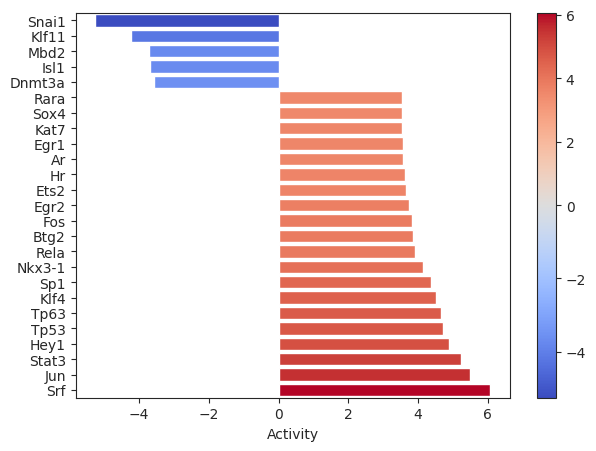

In [40]:
decoupler.plot_barplot(tf_acts, 'Secretory cells', top=25, vertical=True, save = 'secretory_cell_collectTRI.pdf')

In [41]:
# Infer pathway activities with multivariate linear model (mlm)
# It fits a linear model that predicts the observed gene expression based on all pathways’ Pathway-Gene interactions weights. 
# Once fitted, the obtained t-values of the slopes are the scores. 
# If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.
pathway_acts, pathway_pvals = decoupler.run_mlm(mat=mat, net=progeny)

# create a dictionary
data = {"activities": pathway_acts,
        "pvals": pathway_pvals}
df = pd.concat(data, axis = 0)
df.to_csv('/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/Secretory_cells_NTCU_vs_Control_progeny_results.csv')

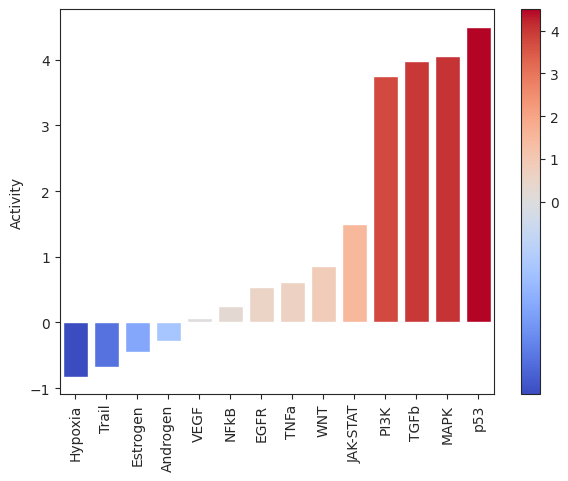

In [42]:
decoupler.plot_barplot(pathway_acts, 'Secretory cells', top=25, vertical=False, save = 'secretory_cell_progeny.pdf')

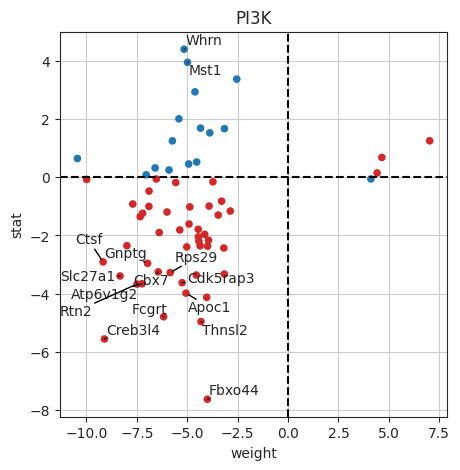

In [43]:
decoupler.plot_targets(results_df, stat='stat', source_name='PI3K', net=progeny, top=15, save = 'secretory_cell_progeny_PI3K.pdf')

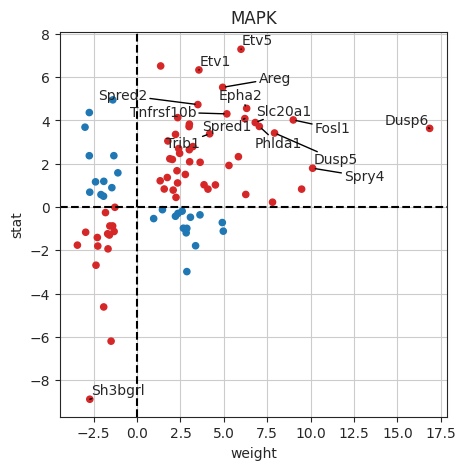

In [44]:
decoupler.plot_targets(results_df, stat='stat', source_name='MAPK', net=progeny, top=15, save = 'secretory_cell_progeny_MAPK.pdf')

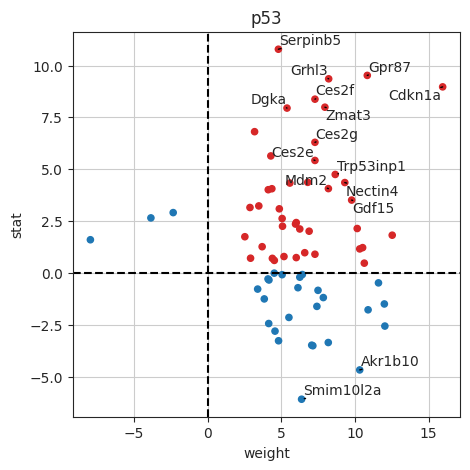

In [45]:
decoupler.plot_targets(results_df, stat='stat', source_name='p53', net=progeny, top=15, save = 'secretory_cell_progeny_p53.pdf')

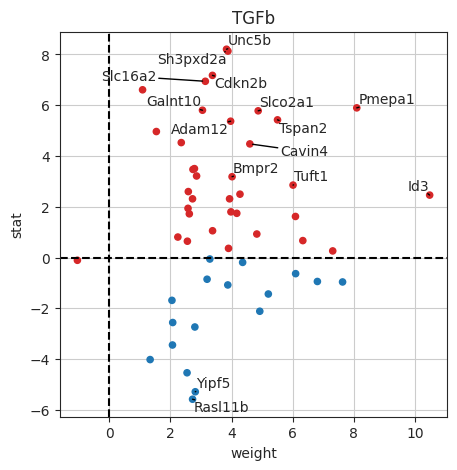

In [46]:
decoupler.plot_targets(results_df, stat='stat', source_name='TGFb', net=progeny, top=15, save = 'secretory_cell_progeny_TGFb.pdf')

In [47]:
# Infer enrichment with over representation analysis (ora) using significant deg
# As input data it accepts the results of differential expression analysis (decoupler.run_ora_df).
# For this a user-defined significance filtering can be used. 
# Once we have S*, it builds a contingency table using set operations for each set stored in the gene set resource being used (net).
# Using the contingency table, ora performs a one-sided Fisher exact test to test for significance of overlap between sets. 
# The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.
top_genes = results_df[results_df['padj'] < 0.05].reset_index()
top_genes['group'] = 'Secretory cells'
top_genes = top_genes.sort_values('log2FoldChange', key = np.abs, ascending = False)
enr_pvals = decoupler.get_ora_df(top_genes, mouse_msigdb, groupby='group', features='index', source='geneset', target='genesymbol')

# create a dictionary
data = {"pvals": enr_pvals}
df = pd.concat(data, axis = 0)
df.to_csv('/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/Secretory_cells_NTCU_vs_Control_GSEA_results.csv')

# Set 0s to min p-value
enr_pvals.values[enr_pvals.values == 0] = np.min(enr_pvals.values[enr_pvals.values != 0])

# Log-transform
enr_pvals = -np.log10(enr_pvals)

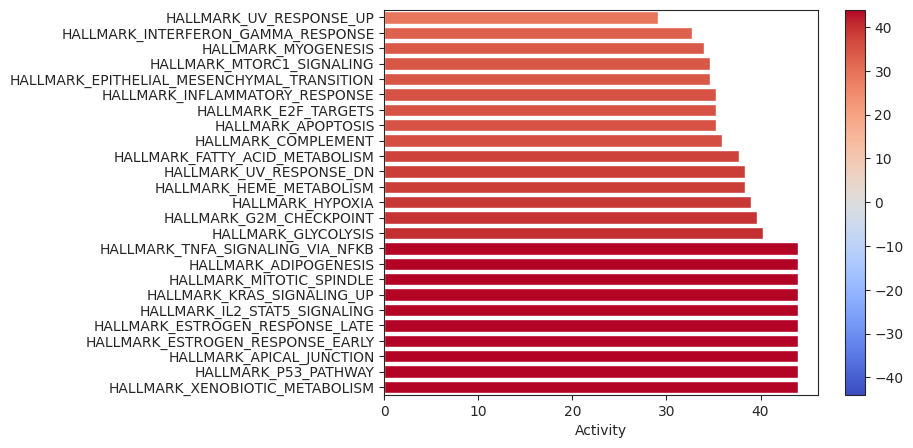

In [48]:
decoupler.plot_barplot(enr_pvals, 'Secretory cells', top=25, vertical=True)

### ANALYSE SECRETORY CELLS - CONTROL VS. TREATMENT

In [81]:
# Select basal cell profiles
secretory_cells = pdata[pdata.obs['epithelial_celltypes'] == 'Club/Secretory cells'].copy()

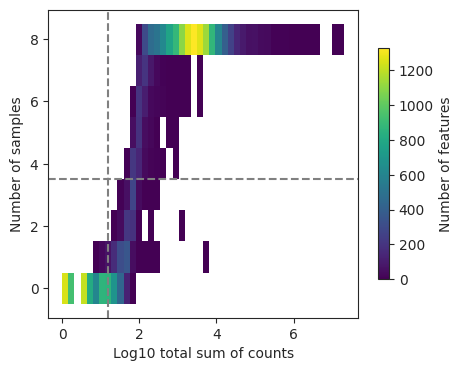

In [82]:
decoupler.plot_filter_by_expr(secretory_cells, group='phenotype', min_count=10, min_total_count=15)

In [83]:
# Obtain genes that pass the thresholds
genes = decoupler.filter_by_expr(secretory_cells, group='phenotype', min_count=10, min_total_count=15)

# Filter by these genes
secretory_cells = secretory_cells[:, genes].copy()

# Build DESeq2 object
dds = DeseqDataSet(
    adata=secretory_cells,
    design_factors=['phenotype', 'age'],
    refit_cooks=True,
    n_cpus=8,
)

# Compute LFCs
dds.deseq2()

# Extract contrast between NTCU-treated vs control
stat_res = DeseqStats(dds, contrast=["phenotype", 'Control', 'NTCU-treated'], n_cpus=8)

# Compute Wald test
stat_res.summary()

# Shrink LFCs
stat_res.lfc_shrink(coeff='phenotype_NTCU-treated_vs_Control')

# Extract results
results_df = stat_res.results_df
results_df.to_csv("/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/NTCU_DESeq2_Secretory_cells_Control_vs_NTCU.csv")

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 10.99 seconds.

Fitting dispersion trend curve...
... done in 4.14 seconds.

Fitting MAP dispersions...
... done in 10.65 seconds.

Fitting LFCs...
... done in 1.76 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.81 seconds.

Log2 fold change & Wald test p-value: phenotype Control vs NTCU-treated


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0610009B22Rik,426.337891,0.361981,0.355024,1.019594,3.079212e-01,4.386277e-01
0610009E02Rik,43.348442,0.553558,0.269410,2.054707,3.990733e-02,9.428723e-02
0610009L18Rik,106.529572,0.854969,0.209854,4.074121,4.618852e-05,3.786648e-04
0610010F05Rik,187.880524,-0.215351,0.153718,-1.400944,1.612307e-01,2.705772e-01
0610010K14Rik,672.524658,0.368926,0.210303,1.754259,7.938612e-02,1.586226e-01
...,...,...,...,...,...,...
mt-Nd3,616.939514,0.535291,0.092281,5.800679,6.604698e-09,1.499277e-07
mt-Nd4,30419.507812,0.784912,0.170523,4.602953,4.165431e-06,4.684298e-05
mt-Nd4l,52205.496094,0.682599,0.166650,4.095995,4.203595e-05,3.497666e-04
mt-Nd5,23240.312500,0.964058,0.195729,4.925474,8.415601e-07,1.140202e-05


Fitting MAP LFCs...
... done in 2.17 seconds.

Shrunk Log2 fold change & Wald test p-value: phenotype Control vs NTCU-treated


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0610009B22Rik,426.337891,-0.206639,0.317560,1.019594,3.079212e-01,4.386277e-01
0610009E02Rik,43.348442,-0.435860,0.260230,2.054707,3.990733e-02,9.428723e-02
0610009L18Rik,106.529572,-0.777519,0.218897,4.074121,4.618852e-05,3.786648e-04
0610010F05Rik,187.880524,0.191380,0.147074,-1.400944,1.612307e-01,2.705772e-01
0610010K14Rik,672.524658,-0.300888,0.209994,1.754259,7.938612e-02,1.586226e-01
...,...,...,...,...,...,...
mt-Nd3,616.939514,-0.520805,0.091984,5.800679,6.604698e-09,1.499277e-07
mt-Nd4,30419.507812,-0.873686,0.167049,4.602953,4.165431e-06,4.684298e-05
mt-Nd4l,52205.496094,-0.688031,0.163659,4.095995,4.203595e-05,3.497666e-04
mt-Nd5,23240.312500,-0.926279,0.193305,4.925474,8.415601e-07,1.140202e-05


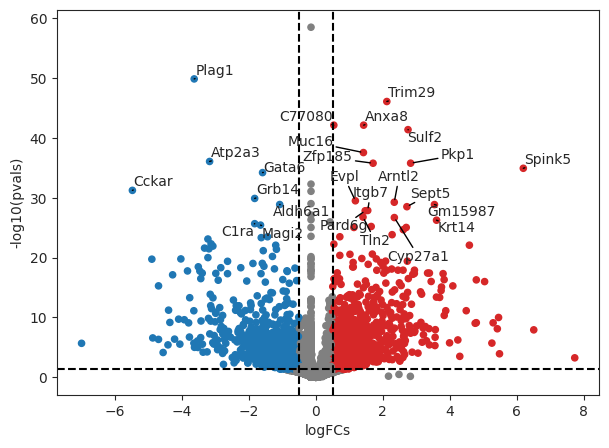

In [84]:
decoupler.plot_volcano_df(results_df, x='log2FoldChange', y='padj', top=25, save = "secretory_cell_volcano_control.pdf")

In [ ]:
# create matrix format for input to downstream analysis
mat = results_df[['stat']].T.rename(index={'stat': 'Secretory cells'})

# Infer pathway activities with univariate linear model (ulm)
# For each sample in our dataset (mat) and each TF in our network (net), it fits a linear model
# that predicts the observed gene expression based solely on the TF’s TF-Gene interaction weights. 
# Once fitted, the obtained t-value of the slope is the score. 
# If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive.
tf_acts, tf_pvals = decoupler.run_ulm(mat=mat, net=collectri)

# create a dictionary
data = {"activities": tf_acts,
        "pvals": tf_pvals}

df = pd.concat(data,
               axis = 0)
df.to_csv('/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/Secretory_cells_Control_vs_NTCU_collectTRI_results.csv')

In [ ]:
decoupler.plot_barplot(tf_acts, 'Secretory cells', top=25, vertical=True, save = 'secretory_cell_collectTRI_Control.pdf')

In [ ]:
# Infer pathway activities with multivariate linear model (mlm)
# It fits a linear model that predicts the observed gene expression based on all pathways’ Pathway-Gene interactions weights. 
# Once fitted, the obtained t-values of the slopes are the scores. 
# If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.
pathway_acts, pathway_pvals = decoupler.run_mlm(mat=mat, net=progeny)

# create a dictionary
data = {"activities": pathway_acts,
        "pvals": pathway_pvals}
df = pd.concat(data, axis = 0)
df.to_csv('/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/Secretory_cells_Control_vs_NTCU_progeny_results.csv')

In [ ]:
decoupler.plot_barplot(pathway_acts, 'Secretory cells', top=25, vertical=False, save = 'secretory_cell_progeny_Control.pdf')

In [ ]:
# Infer enrichment with over representation analysis (ora) using significant deg
# As input data it accepts the results of differential expression analysis (decoupler.run_ora_df).
# For this a user-defined significance filtering can be used. 
# Once we have S*, it builds a contingency table using set operations for each set stored in the gene set resource being used (net).
# Using the contingency table, ora performs a one-sided Fisher exact test to test for significance of overlap between sets. 
# The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.
top_genes = results_df[results_df['padj'] < 0.05].reset_index()
top_genes['group'] = 'Secretory cells'
top_genes = top_genes.sort_values('log2FoldChange', key = np.abs, ascending = False)
enr_pvals = decoupler.get_ora_df(top_genes, mouse_msigdb, groupby='group', features='index', source='geneset', target='genesymbol')

# create a dictionary
data = {"pvals": enr_pvals}
df = pd.concat(data, axis = 0)
df.to_csv('/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/Secretory_cells_Control_vs_NTCU_GSEA_results.csv')

# Set 0s to min p-value
enr_pvals.values[enr_pvals.values == 0] = np.min(enr_pvals.values[enr_pvals.values != 0])

# Log-transform
enr_pvals = -np.log10(enr_pvals)

In [ ]:
decoupler.plot_barplot(enr_pvals, 'Secretory cells', top=25, vertical=True)

### ANALYSE PROLIFERATIVE BASAL CELLS

In [49]:
# Select basal cell profiles
prolif_basal_cells = pdata[pdata.obs['epithelial_celltypes'] == 'Proliferative basal cells'].copy()

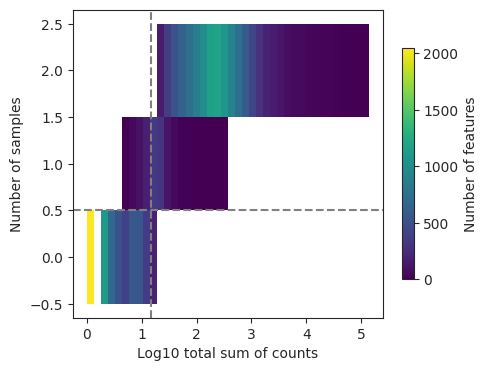

In [50]:
decoupler.plot_filter_by_expr(prolif_basal_cells, group='phenotype', min_count=10, min_total_count=15)

In [51]:
# Obtain genes that pass the thresholds
genes = decoupler.filter_by_expr(prolif_basal_cells, group='phenotype', min_count=10, min_total_count=15)

# Filter by these genes
prolif_basal_cells = prolif_basal_cells[:, genes].copy()

# Build DESeq2 object
dds = DeseqDataSet(
    adata=prolif_basal_cells,
    design_factors=['phenotype'],
    refit_cooks=True,
    n_cpus=8,
)

# Compute LFCs
dds.deseq2()

# Extract contrast between NTCU-treated vs control
stat_res = DeseqStats(dds, contrast=["phenotype", 'NTCU-treated', 'Control'], n_cpus=8)

# Compute Wald test
stat_res.summary()

# Shrink LFCs
stat_res.lfc_shrink(coeff='phenotype_NTCU-treated_vs_Control')

# Extract results
results_df = stat_res.results_df
results_df.to_csv("/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/NTCU_DESeq2_Proliferative_Basal_cells_NTCU_vs_Control.csv")

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...


/software/team152/mp34/miniconda3/envs/milopy/lib/python3.9/site-packages/numpy/linalg/linalg.py:2094: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/software/team152/mp34/miniconda3/envs/milopy/lib/python3.9/site-packages/numpy/linalg/linalg.py:2094: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/software/team152/mp34/miniconda3/envs/milopy/lib/python3.9/site-packages/numpy/linalg/linalg.py:2094: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/software/team152/mp34/miniconda3/envs/milopy/lib/python3.9/site-packages/numpy/linalg/linalg.py:2094: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/software/team152/mp34/miniconda3/envs/milopy/lib/python3.9/site-packages/numpy/linalg/linalg.py:2094: RuntimeWarning: inval

... done in 10.69 seconds.

Fitting dispersion trend curve...
... done in 4.33 seconds.

Fitting MAP dispersions...
... done in 8.07 seconds.

Fitting LFCs...
... done in 1.45 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.79 seconds.

Log2 fold change & Wald test p-value: phenotype NTCU-treated vs Control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0610009B22Rik,162.030396,0.224897,0.176823,1.271874,2.034178e-01,4.403284e-01
0610009L18Rik,26.319485,-0.393341,0.417693,-0.941699,3.463469e-01,5.883676e-01
0610010F05Rik,53.828094,-0.512330,0.290689,-1.762466,7.799056e-02,2.472519e-01
0610010K14Rik,415.943787,-0.139060,0.106692,-1.303378,1.924459e-01,4.283323e-01
0610012G03Rik,243.007034,0.256000,0.164609,1.555206,1.198970e-01,3.233391e-01
...,...,...,...,...,...,...
mt-Nd3,55.637493,-0.779810,0.284503,-2.740951,6.126161e-03,4.258126e-02
mt-Nd4,2844.535156,-1.301124,0.040313,-32.275358,1.551138e-228,2.066461e-225
mt-Nd4l,5771.698730,-1.099475,0.028059,-39.184908,0.000000e+00,0.000000e+00
mt-Nd5,2167.137695,-1.492396,0.046755,-31.919512,1.431701e-223,1.716610e-220


Fitting MAP LFCs...
... done in 1.19 seconds.

Shrunk Log2 fold change & Wald test p-value: phenotype NTCU-treated vs Control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0610009B22Rik,162.030396,-0.144270,0.602233,1.271874,2.034178e-01,4.403284e-01
0610009L18Rik,26.319485,-0.144270,0.602233,-0.941699,3.463469e-01,5.883676e-01
0610010F05Rik,53.828094,-0.144270,0.602233,-1.762466,7.799056e-02,2.472519e-01
0610010K14Rik,415.943787,-0.144270,0.602233,-1.303378,1.924459e-01,4.283323e-01
0610012G03Rik,243.007034,0.193834,0.159494,1.555206,1.198970e-01,3.233391e-01
...,...,...,...,...,...,...
mt-Nd3,55.637493,-0.144270,0.602233,-2.740951,6.126161e-03,4.258126e-02
mt-Nd4,2844.535156,-0.144270,0.602233,-32.275358,1.551138e-228,2.066461e-225
mt-Nd4l,5771.698730,-0.144270,0.602235,-39.184908,0.000000e+00,0.000000e+00
mt-Nd5,2167.137695,-0.144270,0.602232,-31.919512,1.431701e-223,1.716610e-220


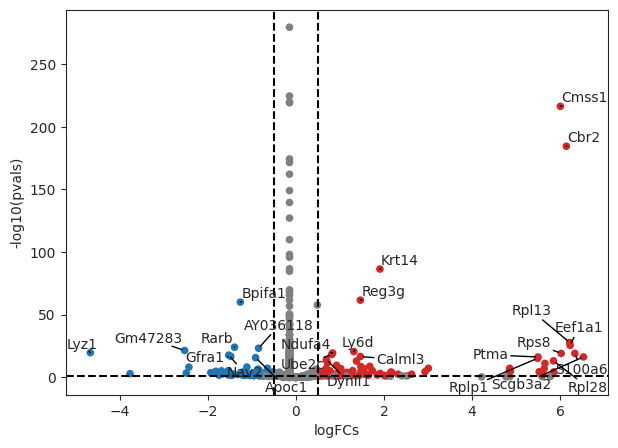

In [52]:
decoupler.plot_volcano_df(results_df, x='log2FoldChange', y='padj', top=25, save = "Proliferative_Basal_cells_volcano.pdf")

In [53]:
# create matrix format for input to downstream analysis
mat = results_df[['stat']].T.rename(index={'stat': 'Proliferative Basal cells'})

# Infer pathway activities with univariate linear model (ulm)
# For each sample in our dataset (mat) and each TF in our network (net), it fits a linear model
# that predicts the observed gene expression based solely on the TF’s TF-Gene interaction weights. 
# Once fitted, the obtained t-value of the slope is the score. 
# If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive.
tf_acts, tf_pvals = decoupler.run_ulm(mat=mat, net=collectri)

# create a dictionary
data = {"activities": tf_acts,
        "pvals": tf_pvals}
df = pd.concat(data, axis = 0)
df.to_csv('/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/Proliferative_basal_cells_NTCU_vs_Control_collectTRI_results.csv')

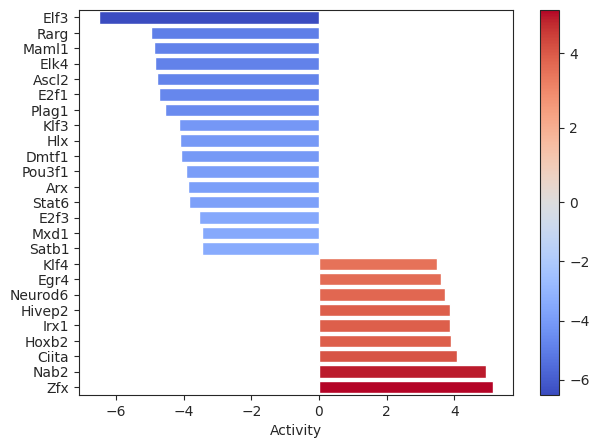

In [54]:
decoupler.plot_barplot(tf_acts, 'Proliferative Basal cells', top=25, vertical=True, save = 'proliferative_basal_cell_collectTRI.pdf')

In [55]:
# Infer pathway activities with multivariate linear model (mlm)
# It fits a linear model that predicts the observed gene expression based on all pathways’ Pathway-Gene interactions weights. 
# Once fitted, the obtained t-values of the slopes are the scores. 
# If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.
pathway_acts, pathway_pvals = decoupler.run_mlm(mat=mat, net=progeny)

# create a dictionary
data = {"activities": pathway_acts,
        "pvals": pathway_pvals}
df = pd.concat(data, axis = 0)
df.to_csv('/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/Proliferative_basal_cells_NTCU_vs_Control_progeny_results.csv')

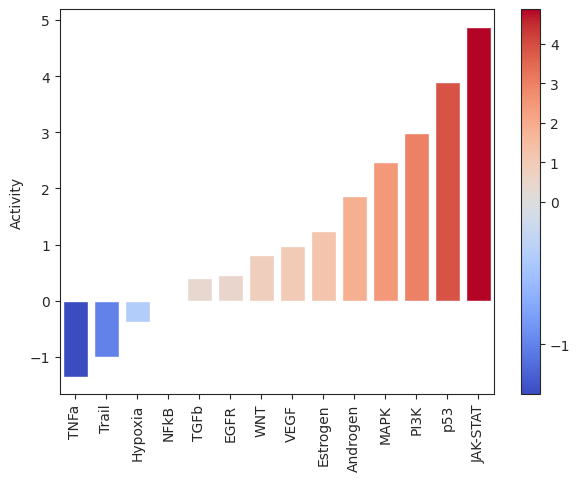

In [56]:
decoupler.plot_barplot(pathway_acts, 'Proliferative Basal cells', top=25, vertical=False, save = 'proliferative_basal_cell_progeny.pdf')

In [57]:
# Infer enrichment with over representation analysis (ora) using significant deg
# As input data it accepts the results of differential expression analysis (decoupler.run_ora_df).
# For this a user-defined significance filtering can be used. 
# Once we have S*, it builds a contingency table using set operations for each set stored in the gene set resource being used (net).
# Using the contingency table, ora performs a one-sided Fisher exact test to test for significance of overlap between sets. 
# The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.
top_genes = results_df[results_df['padj'] < 0.05].reset_index()
top_genes['group'] = 'Proliferative Basal cells'
top_genes = top_genes.sort_values('log2FoldChange', key = np.abs, ascending = False)
enr_pvals = decoupler.get_ora_df(top_genes, mouse_msigdb, groupby='group', features='index', source='geneset', target='genesymbol')

# create a dictionary
data = {"pvals": enr_pvals}
df = pd.concat(data, axis = 0)
df.to_csv('/lustre/scratch126/casm/team154pc/mp34/lung/NTCU/scRNA/Proliferative_basal_cells_NTCU_vs_Control_GSEA_results.csv')

# Set 0s to min p-value
enr_pvals.values[enr_pvals.values == 0] = np.min(enr_pvals.values[enr_pvals.values != 0])

# Log-transform
enr_pvals = -np.log10(enr_pvals)

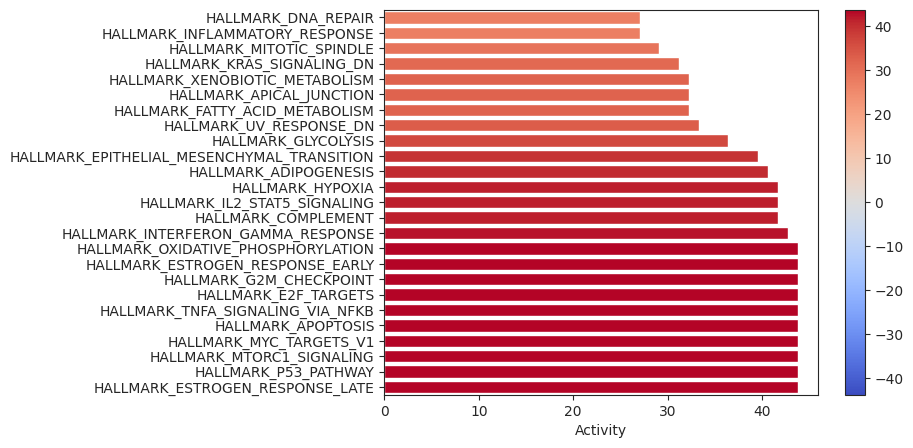

In [58]:
decoupler.plot_barplot(enr_pvals, 'Proliferative Basal cells', top=25, vertical=True)